<a href="https://colab.research.google.com/drive/1W7apBKuj6rtr55d-qVvl7GXTBiapf105?usp=sharing" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformeur : génération de melodies

#### Importations

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import math

In [2]:
#path local
sys.path.append('C:/Users/jeffs/Desktop/M2')
sys.path.append('C:/Users/jeffs/Desktop/M2/data')
sys.path.append('C:/Users/jeffs/Desktop/M2/Transformer')

In [3]:
#from melodygenerator import *
from melodypreprocessor import *
from train import *
from transformer import *
from extract_data import *
from visualization import *

### Extraction des données des fichiers xml

In [4]:
#Extractions des partitions a partir des fichiers xml
path_to_xml= "data/data_xml"
file_output= "data/data.json"

D= data_to_json(path_to_xml)
with open(file_output, 'w',encoding="utf-8") as f:
    json.dump(D,f,indent=2)
print(f'{file_output} with {len(D)} scores created.')


data/data.json with 171 scores created.


### Extractions des mélodies

In [7]:
#Extraction des melodies par partie
filename="dataset4"
size_melody= 4 #en mesure ( 1000 = max de la partie )
time_signatures=set(["2/4"]) #prend toutes les time signatures par default

parts_len=json_into_part_melody("data/data.json",output_file=filename,size=size_melody,time_signatures=time_signatures)
print("Toutes les melodies ont étés générées par parties. Tailles des parties : "+" ".join([f"{key} : {length} " for key,length in parts_len]))


Toutes les melodies ont étés générées par parties. Tailles des parties : B : 2131  C : 1226  A : 2451  D : 18 


### Création du modèle

In [8]:
melody_preprocessor = MelodyPreprocessor("data/dataset4A.json", batch_size=32)
train_dataset = melody_preprocessor.create_training_dataset()
vocab_size = melody_preprocessor.number_of_tokens_with_padding
transformer_model = Transformer(
    num_layers=2,
    d_model=64,
    num_heads=2,
    d_feedforward=128,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    max_num_positions_in_pe_encoder=384,
    max_num_positions_in_pe_decoder=384,
    dropout_rate=0.2,
)
nb_batchs=len(train_dataset)

### Entrainement du modèle

In [9]:
iters,losses=train(train_dataset, transformer_model,1)

Training the model...
Epoch 1 Batch 1 Loss 5.651585102081299
Epoch 1 Batch 2 Loss 5.374663829803467
Epoch 1 Batch 3 Loss 5.013549327850342
Epoch 1 Batch 4 Loss 4.913417339324951
Epoch 1 Batch 5 Loss 4.738144397735596
Epoch 1 Batch 6 Loss 4.727787971496582
Epoch 1 Batch 7 Loss 4.519947528839111
Epoch 1 Batch 8 Loss 4.550960540771484
Epoch 1 Batch 9 Loss 4.491287708282471
Epoch 1 Batch 10 Loss 4.3972320556640625
Epoch 1 Batch 11 Loss 4.362996578216553
Epoch 1 Batch 12 Loss 4.286412239074707
Epoch 1 Batch 13 Loss 4.30472993850708
Epoch 1 Batch 14 Loss 4.444796085357666
Epoch 1 Batch 15 Loss 4.105393886566162
Epoch 1 Batch 16 Loss 4.157944679260254
Epoch 1 Batch 17 Loss 4.024363994598389
Epoch 1 Batch 18 Loss 4.109440803527832
Epoch 1 Batch 19 Loss 3.9870033264160156
Epoch 1 Batch 20 Loss 3.857555389404297
Epoch 1 Batch 21 Loss 3.851032018661499
Epoch 1 Batch 22 Loss 3.7364399433135986
Epoch 1 Batch 23 Loss 3.8389556407928467
Epoch 1 Batch 24 Loss 3.7656373977661133
Epoch 1 Batch 25 Loss 3

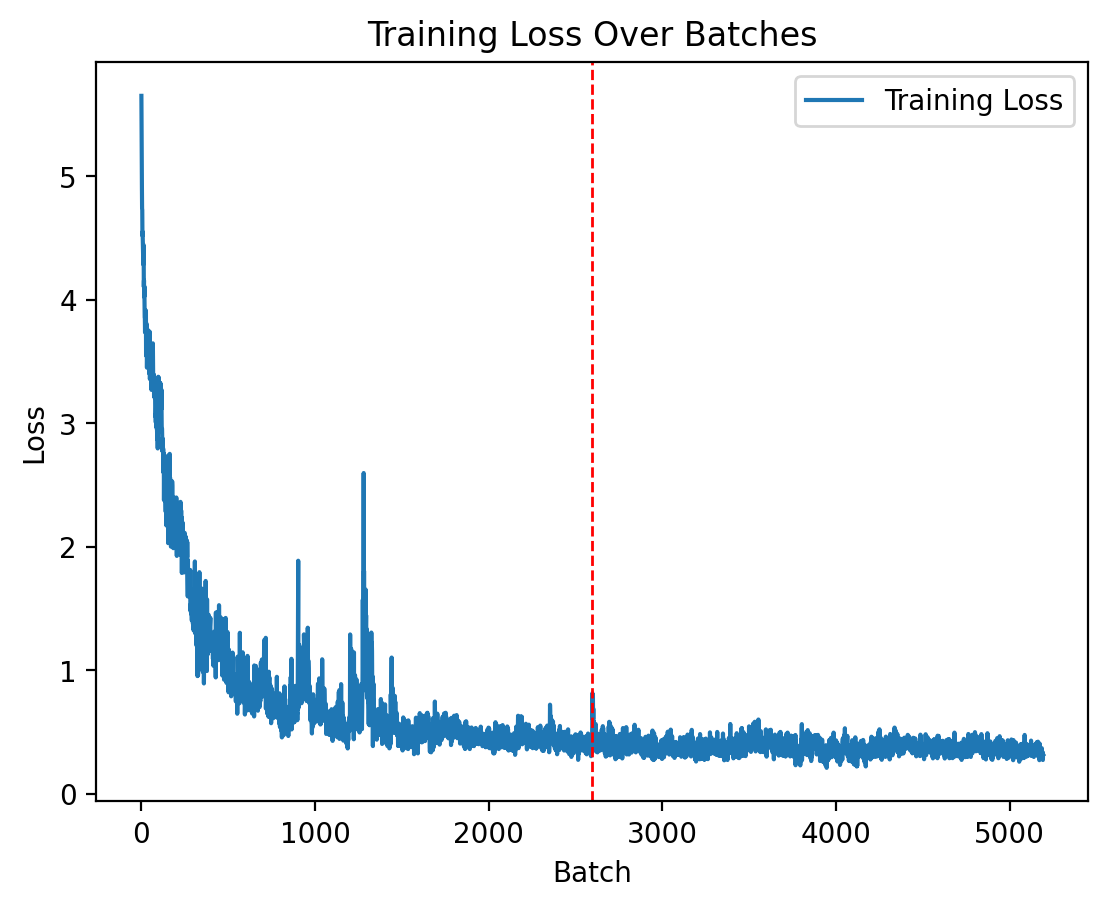

In [10]:
def plot_losses(iters,losses,batchs):
    plt.plot(iters,losses, label='Training Loss')
    for i in range(batchs,len(iters),batchs):
        plt.axvline(x=i, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Batches')
    plt.legend()
    plt.show()

plot_losses(iters,losses,nb_batchs)

### Génération

### Parametres

In [ ]:
melodie_size = 4 #Taille de la mélodie originale qu'on utilise
lg_debut = 2 #Nombre de mesures pour la sequence initiale
lg_predict = 2 #Nombre de mesures pour la sequence prédite
nb_melodies= 10
max_notes = 8*lg_debut+8*lg_predict

MODE_DECALAGE=False #On prend lg_debut mesure de l'original pour prédire lg_predict et on decale
RANDOM_START=False #On commence la mélodie a une mesure aléatoire de la partie ( pour ne pas forcément avoir que les débuts)


melody_generator = MelodyGenerator(
    transformer_model, melody_preprocessor.tokenizer,max_notes
)

In [ ]:
error_part_A= ['Sarau para Radamés','DESPREZADO','ACARICIANDO','Dino Pintando o Sete Cordas','Ja Te Digo','CHORANDO','É DO QUE HÁ','O BOÊMIO']
melodies_generated=[]
mode=0 #0 highest prob   #2 categorical + temperature + topk sampling
forcing=0 #entre 0 et 1, pourcentage de chance d'utiler les notes extraites de l'originale lors de la prédiction
top_k=10

for _ in range(nb_melodies):
    print("Generating a melody...")
    seq=extract_random_seq("assets/data.json",1,"A")
    print(f'Titre de l_original : {seq[0]}')
    original= extract_seq_from("assets/data.json",seq[0],seq[2],mode="mesure")[-1]

    #Tant que la partie extraite ne correspond pas a la time signature ou quelle contient des mesures vides ( a fix)
    while seq[1]!= "2/4" or (seq[0] in error_part_A and MODE_DECALAGE):
        seq=extract_random_seq("assets/data.json",1,"A")
        original= extract_seq_from("assets/data.json",seq[0],seq[2],mode="mesure")[-1]

    if MODE_DECALAGE:
        new_melody,p = generate_decalage(melody_generator,original,lg_debut,lg_seq,mode=mode,k=top_k,first_proba=0.4)
        p = [ prob for proba in p for prob in proba][:len(new_melody)]
        original=[ n for m in original for n in m]
    else:
        index_start= random.randint(0, len(original) - (1+melodie_size)) if RANDOM_START else 0
        debut= original[index_start:index_start+lg_debut]
        original=[ n for m in original[index_start:index_start+melodie_size] for n in m]
        print(index_start)
        print(original)
        debut=[ n for m in debut for n in m]
        print(f'Sequence de départ : {debut}')

        #new_melody
        new_melody,p = melody_generator.generate(debut,forcing=forcing,melody=original,mode=mode,k=10,first_proba=0.6)
        new_melody=new_melody.split(' ')
        new_melody=n_measure(new_melody,lg_predict+lg_debut,"2/4")

        melody_lenght= len(new_melody)
        #proba
        p= [1]*len(debut)+p
        p=p[:melody_lenght]
    melodies_generated.append((seq,new_melody,original,p,index_start))
    print(new_melody)
    print(len(new_melody))
    print(len(p),p)

    print('---------------------')

print('Génération terminée')



#### Enregistrement

In [ ]:
 generated = [ {'Title' : s[0] , "Time_signature" : s[1], 'Part': s[2], 'Key' : s[3] ,'Mesure' : i+1 ,'Generated' : m , 'Original' : o , 'Proba' :[ str(prob) for prob in p ]} for (s,m,o,p,i) in melodies_generated ]

In [ ]:
file_output=f'melody{melodie_size}_' if melodie_size!=1000 else ''
file_output+=f'mode{mode}'
file_output+=f'_top{top_k}' if mode==2 else ''
file_output+=f'_forcing{forcing}' if (forcing>0 and mode==2) else ''
print(file_output)

with open(f'Generated/Transformer/{file_output}.json',"w") as f:
    json.dump(generated,f,indent=2)

## Visualisation

In [35]:
import music21
from music21 import *

#### Toutes les melodies generées

In [36]:
show_all_generated(f"Generated/Transformer/{file_output}.json").show("musicxml")

#### Comparer melodie i avec l'original

In [ ]:
num_melodie=3
score=compare_generated(num_melodie, file_name=f"Generated/Transformer/{file_output}.json")
score.show("musicxml")